In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import copy
import os
from torchsummary import summary
from sklearn.metrics import f1_score

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"
# device = 'cpu'
RESUME = True

CUDA is available!


In [3]:
# supervised_path = "/home/max/Desktop/galaxy_science_display/eight_type/train/"
# val_image_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/validation/"
# test_image_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/test/"
unsupervised_path = "/home/max/Desktop/galaxy_science_display/images_gz2/"
iter1_supervised_path = "/home/max/Desktop/eight_type/train/"
# supervised_path = "/home/max/Desktop/galaxy_science_display/eight_type/train/"
# supervised_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/train"
val_image_path = "/home/max/Desktop/galaxy_science_display/eight_type/validation/"
test_image_path = "/home/max/Desktop/galaxy_science_display/eight_type/test/"


batch_size = 32
train_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(100, 100)),
                                  transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
                                  transforms.ToTensor()])
train_data = ImageFolder(iter1_supervised_path, transform=train_trans)
train_loader = DataLoader(train_data, pin_memory=True, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True)

unsuper_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
                                  transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(200, 200)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
#                                   transforms.RandomResizedCrop((224, 224)),
                                  transforms.ToTensor()])
unsuper_data = ImageFolder(unsupervised_path, transform=unsuper_trans)
unsuper_loader = DataLoader(unsuper_data, pin_memory=True, batch_size=batch_size, shuffle=True)

tensor([1, 0, 1, 6, 7, 6, 4, 7, 6, 4, 1, 7, 7, 0, 6, 5, 6, 1, 7, 7, 0, 5, 6, 0,
        7, 6, 7, 4, 4, 2, 2, 7])
tensor(1)


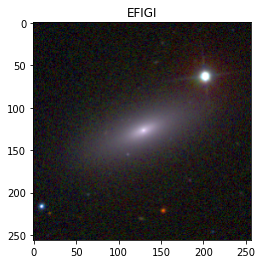

tensor(0)


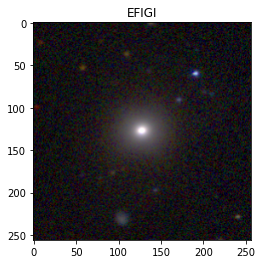

tensor(1)


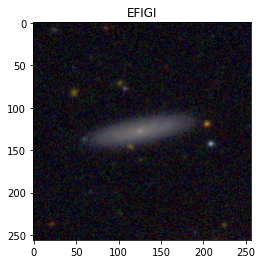

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor(0)


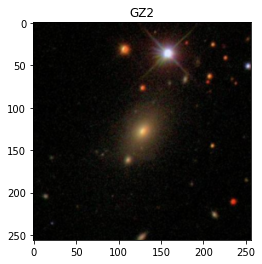

tensor(0)


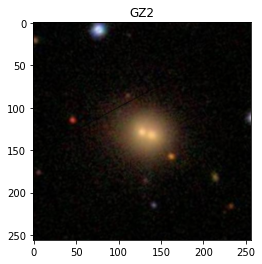

tensor(0)


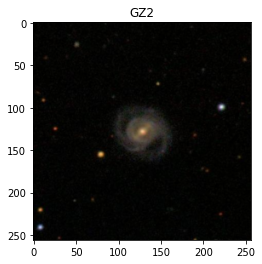

In [4]:
images, labels = next(iter(train_loader))
print(labels)
for i in np.arange(3):
    print(labels[i])
    plt.figure(i)
    plt.title('EFIGI')
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()
    
un_images, un_labels = next(iter(unsuper_loader))
print(un_labels)
for i in np.arange(3):
    print(un_labels[i])
    plt.figure(i)
    plt.title('GZ2')
    plt.imshow(un_images[i].permute(1, 2, 0))
    plt.show()

In [5]:
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
#             nn.Conv2d(256, 512, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
# #             nn.Conv2d(512, 1024, 3, padding=1),
# #             nn.ReLU(),
# #             nn.MaxPool2d(2, 2, 0),
# #             nn.Conv2d(1024, 1024, 3, padding=1)
#         )
#     def forward(self, x):
#         return self.encoder(x)


# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(512, 128, kernel_size=4, stride=4),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128,  64, kernel_size=4, stride=4),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64,  3, kernel_size=2, stride=2),
# #             nn.ReLU(),
# #             nn.ConvTranspose2d(32,  3, kernel_size=2, stride=2),
# #             nn.Sigmoid()
#         )
 
#     def forward(self, x):
#         encode = self.encoder(x)
#         output = self.decoder(encode)
#         return encode, output

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(1024, 1024, 3, padding=1)
        )
    def forward(self, x):
        return self.encoder(x)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.ConvTranspose2d(512,  128, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.ConvTranspose2d(128,  32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,  3, kernel_size=2, stride=2),
        )
 
    def forward(self, x):
        encode = self.encoder(x)
        print(encode)
        output = self.decoder(encode)
        return encode, output

In [7]:
# loss_fn = nn.MSELoss()
# min_loss = 10000.
# # max_loss = 0
# # j = 0
# # model = AutoEncoder().to(device)
# model = torch.load('autoencoder_pretrain_new_version.pkl').to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# judge = True
# for i in range(30):
#     t = tqdm(train_loader)
#     cnt = 0
#     model.train()
#     for x, _ in t:
#         x = x.to(device)
#         optimizer.zero_grad()
        
#         encode, predict = model(x)
# #         print(x.shape)
# #         print(predict.shape)
#         loss = loss_fn(predict, x)
#         loss.backward()
#         t.set_description(f"loss: {loss:.10f}")
#         if loss < min_loss:
#             min_loss = loss
#             torch.save(model, 'autoencoder_pretrain_new_version_testing.pkl')
#         t.refresh()
#         optimizer.step()
        
#         if cnt % 20 == 0:
# #             model.eval()
#             loader = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
#             path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/train/Sc/PGC0053332.png"
#             img = Image.open(path).convert('RGB')
#             image_ori = loader(img).squeeze(0)
#             plt.imshow(image_ori.permute(1, 2, 0))
#             plt.show()
#             image = loader(img).unsqueeze(0)
#             # print(image.shape)
#             image = image.to(device)
#             codes, output = model(image)
#             print("autoencoder:")
#             plt.imshow(output.squeeze().to('cpu').permute(1, 2, 0).detach().numpy())
#             plt.show()
#         cnt += 1
# print()
# print("pretraining is done!")

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = Encoder()
        self.fc = nn.Sequential(
            nn.Linear(16384, 1024),
            nn.Dropout(0.5),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 8),
#             nn.Softmax()
        )
 
    def forward(self, x):
        x = self.encoder(x)
#         x = self.cnn(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [9]:
summary(CNN().to('cuda'), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
             ReLU-11          [-1, 256, 32, 32]               0
        MaxPool2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
             ReLU-14          [-1, 512,

/home/max/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
pre_model = torch.load('autoencoder_pretrain_new_version_EfFIGI_GZ2.pkl')
finetune_model = CNN().to(device) # 14
# print(finetune_model.state_dict())
data = finetune_model.state_dict()
# print(data.keys())
j = 0



for i in finetune_model.parameters():
    if j == 14:
        break
    j += 1
    i.requires_grad=False



# for i in finetune_model.parameters():
#     print(i)
epoch = 1
finetune_model.encoder.load_state_dict(copy.deepcopy(pre_model.encoder.state_dict())) # loads encoder weights from pretrained model
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, finetune_model.parameters()), lr=3e-4)
optimizer = torch.optim.Adam(finetune_model.parameters(), lr=3e-4, weight_decay=0.01)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, finetune_model.parameters()), lr=0.00001)
loss_func = nn.CrossEntropyLoss()



# optimizer = torch.optim.SGD(finetune_model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.01)
# loss_func = nn.CrossEntropyLoss()
# state = {"model":finetune_model.state_dict(), "optimizer":optimizer.state_dict(), "epoch":epoch}
# if not os.path.isdir("checkpoint"):
#     os.mkdir("checkpoint")
# if RESUME:
#     checkpoint_path = "./checkpoint/best_4.pth"
#     checkpoint = torch.load(checkpoint_path)
#     finetune_model.load_state_dict(checkpoint["model"])
#     optimizer.load_state_dict(checkpoint["optimizer"])
#     epoch = checkpoint["epoch"]
#     print(epoch)

In [11]:
# # reg = JacobianReg() # Jacobian regularization
# lambda_JR = 0.01 # hyperparameter
# l1_crit = nn.L1Loss(size_average=False)
# factor = 0.03
n_epochs = 50
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    finetune_model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = finetune_model(x)
#         reg_loss = 0
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        optimizer.step()
        
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(train_loader)
        train_loss += loss/len(train_loader)
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss.item())
    train_acc_record.append(train_acc.item())

    finetune_model.eval()
    for x, y in tqdm(val_loader):
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            prediction = finetune_model(x)
#             reg_loss = 0

#             reg_loss = l1_crit(prediction.argmax(dim = 1), y)

            loss = loss_func(prediction, y)

#             loss = super_loss + factor*reg_loss

    #         loss.backward()
            acc = ((prediction.argmax(dim = 1) == y).float().mean())
            val_acc += acc/len(val_loader)
            val_loss += loss/len(val_loader)
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(finetune_model, "finetune_model_new_version_iter1.pkl")
        print("Model Saved")
#             torch.save(state, "./checkpoint/best_%s.pth" % (str(epoch)))
#             torch.save(finetune_model, 'E_I_S_new.pkl')
    print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
    val_loss_record.append(val_loss.item())
    val_acc_record.append(val_acc.item())
# torch.save(model, 'E_I_Sc.pkl')

  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 1/50 ] loss = 1.64823, acc = 0.37878


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 1/50 ] loss = 1.81780, acc = 0.27586


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 2/50 ] loss = 1.37221, acc = 0.49918


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 2/50 ] loss = 1.69208, acc = 0.42759


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 3/50 ] loss = 1.20874, acc = 0.57063


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 3/50 ] loss = 1.60578, acc = 0.45517


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 4/50 ] loss = 1.12057, acc = 0.61440


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 4/50 ] loss = 1.59271, acc = 0.41379


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 5/50 ] loss = 1.06295, acc = 0.63059


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 5/50 ] loss = 1.51677, acc = 0.45517


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 6/50 ] loss = 1.02536, acc = 0.63137


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 6/50 ] loss = 1.50991, acc = 0.42069


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 7/50 ] loss = 1.02116, acc = 0.63595


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 7/50 ] loss = 1.55093, acc = 0.42759


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 8/50 ] loss = 0.94714, acc = 0.66767


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 8/50 ] loss = 1.50409, acc = 0.37241


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 9/50 ] loss = 0.93788, acc = 0.68163


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 9/50 ] loss = 1.45349, acc = 0.50345


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 10/50 ] loss = 0.95350, acc = 0.66053


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 10/50 ] loss = 1.51200, acc = 0.46207


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 11/50 ] loss = 0.91945, acc = 0.67540


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 11/50 ] loss = 1.46036, acc = 0.44138


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 12/50 ] loss = 0.92398, acc = 0.67479


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 12/50 ] loss = 1.44550, acc = 0.43448


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 13/50 ] loss = 0.89953, acc = 0.67867


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 13/50 ] loss = 1.43031, acc = 0.48966


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 14/50 ] loss = 0.87465, acc = 0.68477


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 14/50 ] loss = 1.40471, acc = 0.48276


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 15/50 ] loss = 0.91022, acc = 0.67852


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 15/50 ] loss = 1.49233, acc = 0.40000


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 16/50 ] loss = 0.88320, acc = 0.68271


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 16/50 ] loss = 1.42319, acc = 0.44828


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 17/50 ] loss = 0.88288, acc = 0.68163


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 17/50 ] loss = 1.37388, acc = 0.51724


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 18/50 ] loss = 0.86452, acc = 0.69340


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 18/50 ] loss = 1.45768, acc = 0.45517


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 19/50 ] loss = 0.87955, acc = 0.69507


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 19/50 ] loss = 1.47185, acc = 0.44828


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 20/50 ] loss = 0.89458, acc = 0.67632


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 20/50 ] loss = 1.41051, acc = 0.49655


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 21/50 ] loss = 0.85637, acc = 0.70146


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 21/50 ] loss = 1.43940, acc = 0.41379


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 22/50 ] loss = 0.82779, acc = 0.71304


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 22/50 ] loss = 1.43927, acc = 0.40000


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 23/50 ] loss = 0.84521, acc = 0.71006


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 23/50 ] loss = 1.37506, acc = 0.51035


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 24/50 ] loss = 0.88149, acc = 0.69370


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 24/50 ] loss = 1.42149, acc = 0.46207


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 25/50 ] loss = 0.83913, acc = 0.70470


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 25/50 ] loss = 1.47637, acc = 0.46207


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 26/50 ] loss = 0.83454, acc = 0.70338


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 26/50 ] loss = 1.42883, acc = 0.51724


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 27/50 ] loss = 0.82722, acc = 0.70322


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 27/50 ] loss = 1.41793, acc = 0.44138


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 28/50 ] loss = 0.84998, acc = 0.70693


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 28/50 ] loss = 1.41661, acc = 0.46897


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 29/50 ] loss = 0.83547, acc = 0.71530


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 29/50 ] loss = 1.45954, acc = 0.45517


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 30/50 ] loss = 0.85207, acc = 0.70397


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 30/50 ] loss = 1.43331, acc = 0.42069


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 31/50 ] loss = 0.85253, acc = 0.70587


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 31/50 ] loss = 1.35740, acc = 0.48276


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 32/50 ] loss = 0.83428, acc = 0.70780


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 32/50 ] loss = 1.34776, acc = 0.54483


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 33/50 ] loss = 0.82042, acc = 0.72079


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 33/50 ] loss = 1.42166, acc = 0.45517


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 34/50 ] loss = 0.78896, acc = 0.73969


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 34/50 ] loss = 1.46768, acc = 0.47586


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 35/50 ] loss = 0.79846, acc = 0.71140


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 35/50 ] loss = 1.38898, acc = 0.44138


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 36/50 ] loss = 0.79068, acc = 0.72540


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 36/50 ] loss = 1.38428, acc = 0.48966


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 37/50 ] loss = 0.82701, acc = 0.70740


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 37/50 ] loss = 1.37570, acc = 0.49655


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 38/50 ] loss = 0.78291, acc = 0.72735


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 38/50 ] loss = 1.45687, acc = 0.45517


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 39/50 ] loss = 0.84885, acc = 0.70844


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 39/50 ] loss = 1.37970, acc = 0.50345


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 40/50 ] loss = 0.79934, acc = 0.72643


  0%|          | 0/145 [00:00<?, ?it/s]

Model Saved
[ Validation | 40/50 ] loss = 1.31621, acc = 0.53793


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 41/50 ] loss = 0.78872, acc = 0.72883


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 41/50 ] loss = 1.35699, acc = 0.50345


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 42/50 ] loss = 0.75934, acc = 0.73910


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 42/50 ] loss = 1.44049, acc = 0.45517


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 43/50 ] loss = 0.84213, acc = 0.70738


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 43/50 ] loss = 1.40911, acc = 0.50345


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 44/50 ] loss = 0.81340, acc = 0.71842


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 44/50 ] loss = 1.42354, acc = 0.48966


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 45/50 ] loss = 0.82076, acc = 0.72437


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 45/50 ] loss = 1.33436, acc = 0.53103


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 46/50 ] loss = 0.76398, acc = 0.75282


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 46/50 ] loss = 1.38159, acc = 0.47586


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 47/50 ] loss = 0.77616, acc = 0.73344


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 47/50 ] loss = 1.45059, acc = 0.42759


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 48/50 ] loss = 0.76335, acc = 0.73625


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 48/50 ] loss = 1.32761, acc = 0.55862


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 49/50 ] loss = 0.81236, acc = 0.71854


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 49/50 ] loss = 1.37986, acc = 0.46897


  0%|          | 0/70 [00:00<?, ?it/s]

[ Train | 50/50 ] loss = 0.79656, acc = 0.72629


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 50/50 ] loss = 1.32451, acc = 0.56552


In [12]:
!nvidia-smi

Sat Dec 11 22:06:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 31%   50C    P2    90W / 200W |   3024MiB /  7973MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# model_fine = torch.load('finetune_model_new_version456.pkl')
actu = []
ai_pred = []
finetune_model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in tqdm(val_loader):
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        prediction = finetune_model(x)
        actu.append(y.to('cpu').numpy()[0])
        ai_pred.append(prediction.argmax().to('cpu').numpy().tolist())
        loss = loss_func(prediction, y)
    #     loss.backward()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        test_acc += acc/len(test_loader)
        test_loss += loss/len(test_loader)
print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

  0%|          | 0/145 [00:00<?, ?it/s]

[ Test ] loss = 1.32451, acc = 0.56552


In [14]:
model = torch.load('finetune_model_new_version_iter1.pkl')
galaxy_type = ['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc']
loss_func = nn.CrossEntropyLoss()
i = 0
data = []
_all = []
for x, y in val_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)/10
#     print(output)
#     break
    out = output.argmax(dim = 1)
#     out = out.to('cpu').numpy()
    ans = galaxy_type[y[0]]
    pre = galaxy_type[out[0]]
    if output[0][out] > 0.4 and ans == pre:
        data.append(output[0][out].item())
        print(output[0][out].item())
        plt.figure(i)
        plt.title(f'Predict: {pre}, Answer: {ans}')
#         if out[0] == 0:

#         elif out[0] == 1:
#             plt.title(f'Predict: {pre}, Answer: {ans}')
#         else:
#             plt.title(f'Predict: S, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
        plt.imshow(x.permute(1, 2, 0))
        plt.show()
    else:
        _all.append(output[0][out].item())
        
#     if i % 10 == 0:
        
#         plt.figure(i)
#         plt.title(f'Predict: {pre}, Answer: {ans}')
# #         if out[0] == 0:
            
# #         elif out[0] == 1:
# #             plt.title(f'Predict: {pre}, Answer: {ans}')
# #         else:
# #             plt.title(f'Predict: S, Answer: {ans}')
#         x = x.squeeze()
#         x = x.to('cpu')
# #         plt.imshow(x.permute(1, 2, 0))
# #         plt.show()

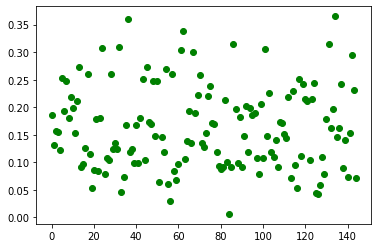

In [15]:
a = []
for i in range(len(_all)):
    a.append(i)
plt.scatter(a, _all, c='green')
b = []
for i in range(len(data)):
    b.append(i)
plt.scatter(b, data, c='red')
plt.show()

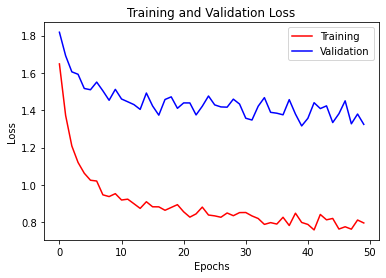

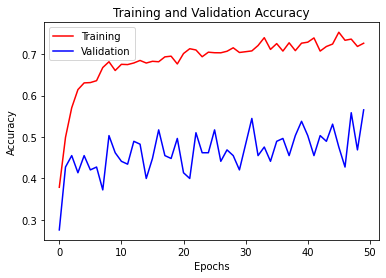

In [16]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [17]:
confmat = confusion_matrix(y_true=actu, y_pred=ai_pred)

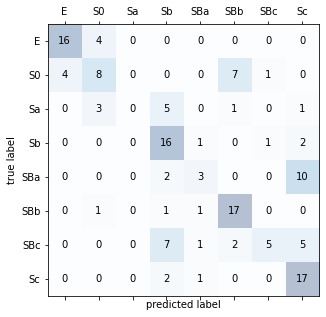

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.show()

In [19]:
f1score = f1_score(actu, ai_pred, average='weighted')
print(f1score)

0.5192717141747445
